In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
from torch.utils.data import DataLoader
from torch import cuda

In [2]:
DIRECTORY = "./CIFAR10"
DEVICE = "cuda" if cuda.is_available() else "cpu"

BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 25
LEARNING_RATE = 0.001

In [3]:
def get_data_loader(directory, batch_size, train=True):
    """
    Returns a DataLoader for the CIFAR-10 dataset.
    Args:
        directory (str): Path to store dataset.
        batch_size (int): Number of samples per batch.
        train (bool): Whether to load the training set.
    """
    # Define transformation functions
    transform_list = [ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    if train:
        transform_list = [RandomCrop(32, padding=4), RandomHorizontalFlip()] + transform_list

    transform = Compose(transform_list)

    dataset = CIFAR10(root=directory, train=train, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=2)


In [4]:
train_loader = get_data_loader(DIRECTORY, BATCH_SIZE, train=True)
test_loader = get_data_loader(DIRECTORY, BATCH_SIZE, train=False)


100%|██████████| 170M/170M [00:21<00:00, 7.82MB/s] 


In [5]:
print(f"Train data shape: {train_loader.dataset.data.shape}")
print(f"Test data shape: {test_loader.dataset.data.shape}")

Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


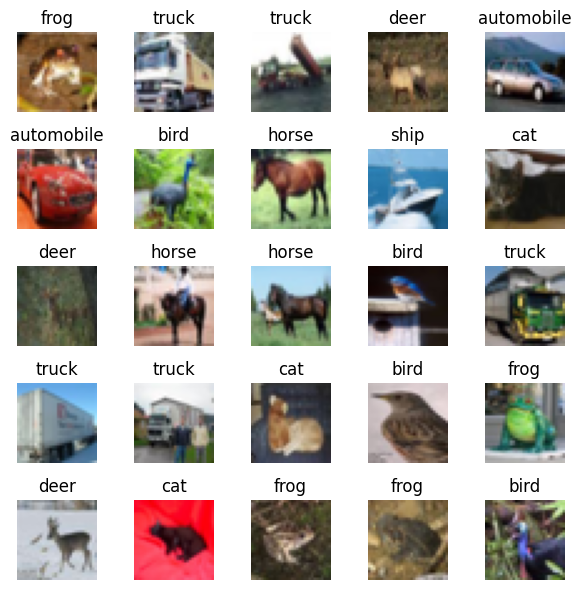

In [6]:
# Plot sample images
fig, axes = plt.subplots(5, 5, figsize=(6, 6))
for idx, ax in enumerate(axes.flatten()):
    sample_image = train_loader.dataset.data[idx]
    label = train_loader.dataset.classes[train_loader.dataset.targets[idx]]
    ax.imshow(sample_image, cmap=plt.cm.binary)
    ax.axis('off')
    ax.set_title(label)
plt.tight_layout()
plt.show()

In [7]:
def view_image(image, label, title):
    img = image.numpy().transpose(1, 2, 0)  # Преобразование в формат HxWxC
    img = img * 0.2023 + 0.4914  # Обратное нормирование (восстановление цветов)
    plt.imshow((img * 255).astype('uint8'))
    plt.title(f"{title}: {class_names[label]}")
    plt.axis('off')
    plt.show()

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f'Classes of dataset: {class_names}')

Classes of dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


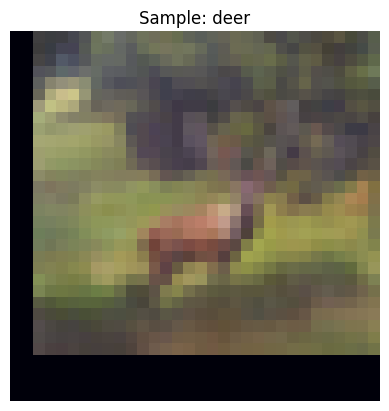

Label: 4


In [10]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
view_image(images[0], labels[0].item(), 'Sample')
print(f'Label: {labels[0].item()}')

In [11]:
print("Обучающая выборка: ")
print(f"Размер данных: {train_loader.dataset.data.shape}")
print(f"Количество меток: {len(train_loader.dataset.targets)}")

print("Тестовая выборка: ")
print(f"Размер данных: {test_loader.dataset.data.shape}")
print(f"Количество меток: {len(test_loader.dataset.targets)}")

Обучающая выборка: 
Размер данных: (50000, 32, 32, 3)
Количество меток: 50000
Тестовая выборка: 
Размер данных: (10000, 32, 32, 3)
Количество меток: 10000


In [12]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [13]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, planes, stride if i == 0 else 1))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


In [14]:
model = ResNet34().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)


In [15]:
def train_model(model, train_loader, num_epochs):
    losses = []  # Store losses for each epoch
    accuracies = []  # Store accuracies for each epoch
    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_accuracy = [], []
        start_time = time.time()

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            epoch_accuracy.append((outputs.argmax(1) == targets).float().mean().item())

        epoch_loss_mean = np.mean(epoch_loss)
        epoch_accuracy_mean = np.mean(epoch_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss_mean:.4f}, Accuracy: {epoch_accuracy_mean:.4f}, Time: {time.time() - start_time:.2f}s")

        losses.append(epoch_loss_mean)
        accuracies.append(epoch_accuracy_mean)

    return losses, accuracies  # Return losses and accuracies for each epoch

In [16]:
# Train the model
losses, accuracies = train_model(model, train_loader, NUM_EPOCHS)

Epoch 1/25, Loss: 1.6370, Accuracy: 0.3872, Time: 24.82s
Epoch 2/25, Loss: 1.2071, Accuracy: 0.5635, Time: 24.59s
Epoch 3/25, Loss: 0.9724, Accuracy: 0.6507, Time: 24.27s
Epoch 4/25, Loss: 0.8139, Accuracy: 0.7134, Time: 24.37s
Epoch 5/25, Loss: 0.7021, Accuracy: 0.7549, Time: 24.76s
Epoch 6/25, Loss: 0.6173, Accuracy: 0.7823, Time: 23.98s
Epoch 7/25, Loss: 0.5558, Accuracy: 0.8061, Time: 24.00s
Epoch 8/25, Loss: 0.5045, Accuracy: 0.8236, Time: 24.19s
Epoch 9/25, Loss: 0.4602, Accuracy: 0.8395, Time: 24.51s
Epoch 10/25, Loss: 0.4227, Accuracy: 0.8531, Time: 24.12s
Epoch 11/25, Loss: 0.3927, Accuracy: 0.8640, Time: 23.97s
Epoch 12/25, Loss: 0.3593, Accuracy: 0.8749, Time: 24.21s
Epoch 13/25, Loss: 0.3425, Accuracy: 0.8799, Time: 24.19s
Epoch 14/25, Loss: 0.3182, Accuracy: 0.8899, Time: 24.17s
Epoch 15/25, Loss: 0.2980, Accuracy: 0.8955, Time: 24.23s
Epoch 16/25, Loss: 0.2797, Accuracy: 0.9010, Time: 24.17s
Epoch 17/25, Loss: 0.2638, Accuracy: 0.9085, Time: 24.14s
Epoch 18/25, Loss: 0.24

In [17]:
torch.save(model.state_dict(), "resnet34.pth")
np.save("loss.npy", np.array(losses))
np.save("accuracy.npy", np.array(accuracies))


In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total, test_loss = 0, 0, 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            correct += (outputs.argmax(1) == targets).sum().item()
            total += targets.size(0)

    print(f"Test Loss: {test_loss / total:.5f}")
    print(f"Test Accuracy: {100. * correct / total:.2f}%")

In [19]:
evaluate_model(model, test_loader)

Test Loss: 0.00391
Test Accuracy: 86.10%
